<a href="https://colab.research.google.com/github/polito-EAD-2026/EAD26-U04.analisi-audio-frequenza/blob/main/EAD26-U04.analisi-audio-frequenza-pt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change with your drive "media" folder
# !ln -s "/content/drive/MyDrive/MyTeaching/Elaborazione-Audio-Digitale/EAD26_docente/EAD-U04.analisi-audio-frequenza/media" media

In [1]:
!git clone "https://github.com/polito-EAD-2026/EAD26-U04.analisi-audio-frequenza.git"
!mv ./EAD26-U04.analisi-audio-frequenza/* .

Cloning into 'EAD26-U04.analisi-audio-frequenza'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 26 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (26/26), 7.85 MiB | 11.64 MiB/s, done.
Resolving deltas: 100% (3/3), done.


# Riferimenti

* [SCIPY] "Spectral Analysis"
  * https://docs.scipy.org/doc/scipy/tutorial/signal.html#tutorial-spectralanalysis
  
* [LERCH] Lerch, "An Introduction to Audio Content Analysis"
  * Ch.3.5 "Instantaneous Features"
    * Spectral Centroid, Spectral Spread, Spectral Rolloff, Zero Crossing Rate, …
  * Code: https://github.com/alexanderlerch/pyACA

* [MULLER] Muller, "Fundamentals of Music Processing"
  * Ch.2 Fourier Analysis of Signals
  * Code: https://audiolabs-erlangen.de/resources/MIR/FMP/C0/C0.html

* [PRAAT] Praat Software - praat.org
  * Weenink, "Speech Signal Processing with Praat"
  * https://www.fon.hum.uva.nl/david/sspbook/sspbook.pdf




In [ ]:
# Install Librosa
!pip install -q librosa praat-parselmouth sox
!pip install -q ipympl mpl_interactions

In [ ]:
import librosa
import librosa.display
import numpy as np
import scipy.signal as signal
import parselmouth

import matplotlib
import matplotlib.pyplot as plt


import IPython
import IPython.display as ipd

import ipywidgets as widgets
import mpl_interactions.ipyplot as iplt

# warning: restart session after pip install ipympl
# %matplotlib widget
%matplotlib inline

from google.colab import output
output.enable_custom_widget_manager()

matplotlib.rcParams.update({'font.size': 14})

import IPython
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from pprint import pprint

from scipy import signal

In [ ]:

def plot_vs_time(w, t, xlim=None, ylim=[-1, +1], fig=None, fmt='-'):
  fig, ax = plt.subplots(figsize=(12,3)) if fig is None else fig
  ax.plot(t,w,fmt)
  ax.set_xlabel('Time (s)')
  ax.set_ylabel('Amplitude')
  ax.set_xlim(xlim) if xlim is not None else plt.xlim(t[0],t[-1])
  ax.set_ylim(ylim) if ylim is not None else None
  fig.tight_layout()
  ax.grid(visible=True)
  # plt.show()

[array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6])]

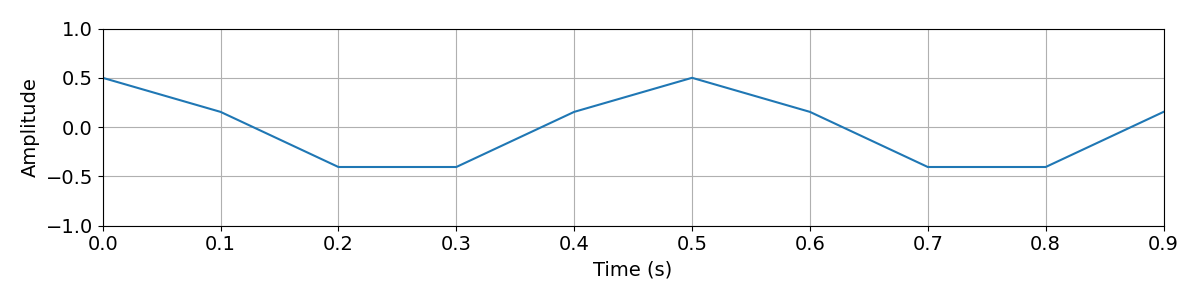

In [ ]:
# Sintesi tono puro

import numpy as np
N, Fs, A, f = 10, 10, 0.5, 2
t = np.arange(N) / Fs
s = A * np.cos(2 * np.pi * f * t)
plot_vs_time(s,t)

[t, (2 * np.pi * f * t) / np.pi]

In [ ]:
# Aliasing

@interact(
    f = widgets.IntSlider(min=1, max=15, step=1, value=4, continuous_update=False),
)
def demo_aliasing(f):
  fig, ax = plt.subplots(figsize=(9,3.1))
  A = 0.5

  N, Fs = 10, 10
  t = np.arange(N) / Fs
  s = A * np.sin(2 * np.pi * f * t)
  plot_vs_time(s,t, fmt='-*', fig=(fig, ax))

  N, Fs = 100, 100
  t = np.arange(N) / Fs
  s = A * np.sin(2 * np.pi * f * t)
  plot_vs_time(s,t, fmt='-', fig=(fig, ax))

  ax.set_xlim(-0.1, 1.1)

interactive(children=(IntSlider(value=4, continuous_update=False, description='f', max=15, min=1), Output()), …

In [ ]:
def gen_cos(dur=1, Fs=100, amp=1, freq=2, phase=0):
    num_samples = int(Fs * dur)
    t = np.arange(num_samples) / Fs
    x = amp * np.cos( (2*np.pi*freq*t) + phase)
    return x, t

def gen_cos_d(dur=1, Fs=100, amp=1, freq=2, delay=0):
    num_samples = int(Fs * dur)
    t = np.arange(num_samples) / Fs
    x = amp * np.cos(2*np.pi*freq*(t-delay))
    return x, t

In [ ]:
def dft(x, Fs, N=None):
  L = len(x)
  N = L if N is None else N
  X = np.fft.rfft(x, N)
  X_ = np.abs(X) / (L/2)
  freq = np.fft.rfftfreq(N, d=1./Fs)
  # X_ = X_[:N//2+1]
  # freq = freq[:N//2+1]
  X_dBFS = 20*np.log10(X_)
  return X_dBFS, freq

def RMS(x):
  return np.sqrt(np.mean(x**2))

def dBFS(x):
  return 20*np.log10(RMS(x))


In [ ]:
# plot frequency spectrum
def plot_vs_freq(X, f, Fs, N=None, xlim=None, ylim=None, fig=None, zp=False):
  xlim = [np.min(f), np.max(f)] if xlim is None else xlim
  ylim = [-60, +6] if ylim is None else ylim

  fig, ax = plt.subplots(figsize=(6,3)) if fig is None else fig

  # ax.stem(f, X, bottom=-100, basefmt=" ", label=f"N={N}")

  """
  print('len(X_dBFS): ', len(X_dBFS), 'len(freq): ', len(freq))
  print('len(x):', len(x))
  print('freq:', freq)
  """

  ax.plot(f, X, '-')
  # ax.semilogx(f, X, '-')  # Sets the x-axis to logarithmic scale


  ax.set_xlabel('Frequency (Hz)')
  ax.set_ylabel('Magnitude (dBFS)') # Modulo
  # print(f'N: {N}, freq: {np.min(freq)}, {np.max(freq)}')
  # plt.xlim([np.min(freq), -np.min(freq)])
  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  plt.grid(visible=True);
  plt.tight_layout()

# plot_vs_freq(x, Fs, N)
# plot_vs_freq(x, Fs, N, xlim=[2, 5], ylim=[-10, 3])



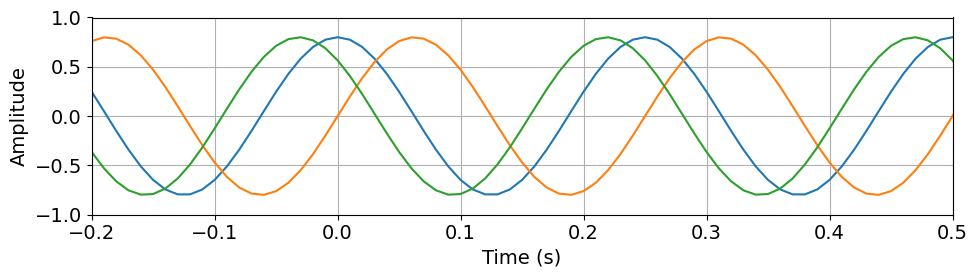

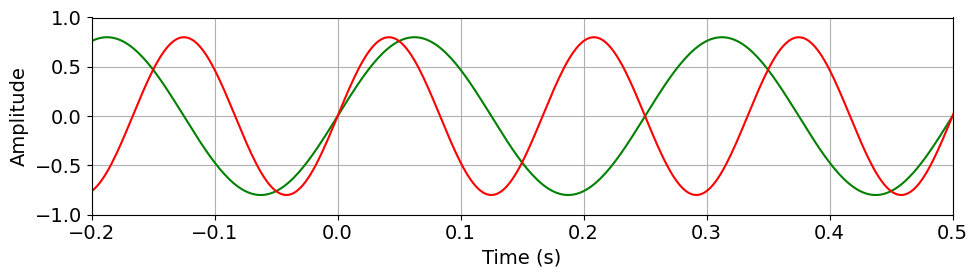

In [ ]:
# EFFETTO DELLA FASE
# n.b. gen_cos e gen_cos_d implementate (come _) per generare coseno _simmetrico_ rispetto all'origine

def gen_cos_(dur=1, Fs=100, amp=1, freq=2, phase=0):
    num_samples = int(Fs * dur)
    t = np.arange(-num_samples,num_samples) / Fs
    x = amp * np.cos( (2*np.pi*freq*t) + phase)
    return x, t

def gen_cos_d_(dur=1, Fs=100, amp=1, freq=2, delay=0):
    num_samples = int(Fs * dur)
    t = np.arange(-num_samples,num_samples) / Fs
    x = amp * np.cos(2*np.pi*freq*(t-delay))
    return x, t
    f = 4

fig, ax = plt.subplots(figsize=(10,3))
f = 4
x0,t = gen_cos_(dur=1, Fs=100, amp=0.8, freq=f, phase=0)
plot_vs_time(x0,t, xlim=(-0.2,0.5), fig=(fig,ax), fmt='-')
x0,t = gen_cos_(dur=1, Fs=100, amp=0.8, freq=f, phase=-np.pi/2)
plot_vs_time(x0,t, xlim=(-0.2,0.5), fig=(fig,ax), fmt='-')
x0,t = gen_cos_(dur=1, Fs=100, amp=0.8, freq=f, phase=np.pi/4)
plot_vs_time(x0,t, xlim=(-0.2,0.5), fig=(fig,ax), fmt='-')


fig, ax = plt.subplots(figsize=(10,3))
Fs = 500
f = 4
ph = -np.pi/2
x0,t = gen_cos_(dur=1, Fs=Fs, amp=0.8, freq=f, phase=-np.pi/2)
plot_vs_time(x0,t, xlim=(-0.2,0.5), fig=(fig,ax), fmt='-g')
f = 6
x0,t = gen_cos_(dur=1, Fs=Fs, amp=0.8, freq=f, phase=-np.pi/2)
plot_vs_time(x0,t, xlim=(-0.2,0.5), fig=(fig,ax), fmt='-r')


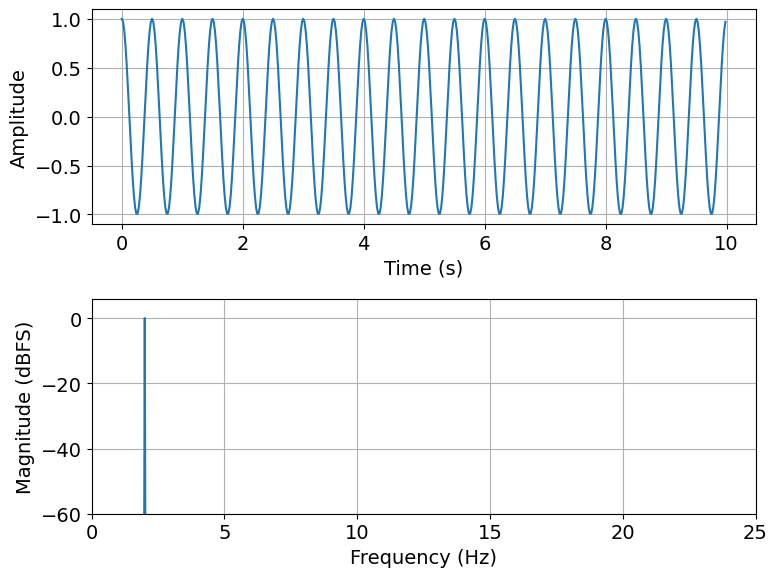

In [ ]:
Fs = 50
dur = 10
x, t = gen_cos(dur=dur, Fs=Fs, amp=1, freq=2, phase=0)

fig, ax = plt.subplots(2,1,figsize=(8,6))
plot_vs_time(x, t, ylim = [-1.1, +1.1], fig=(fig,ax[0]))

X, f = dft(x, Fs)
plot_vs_freq(X, f, Fs, fig=(fig,ax[1]))

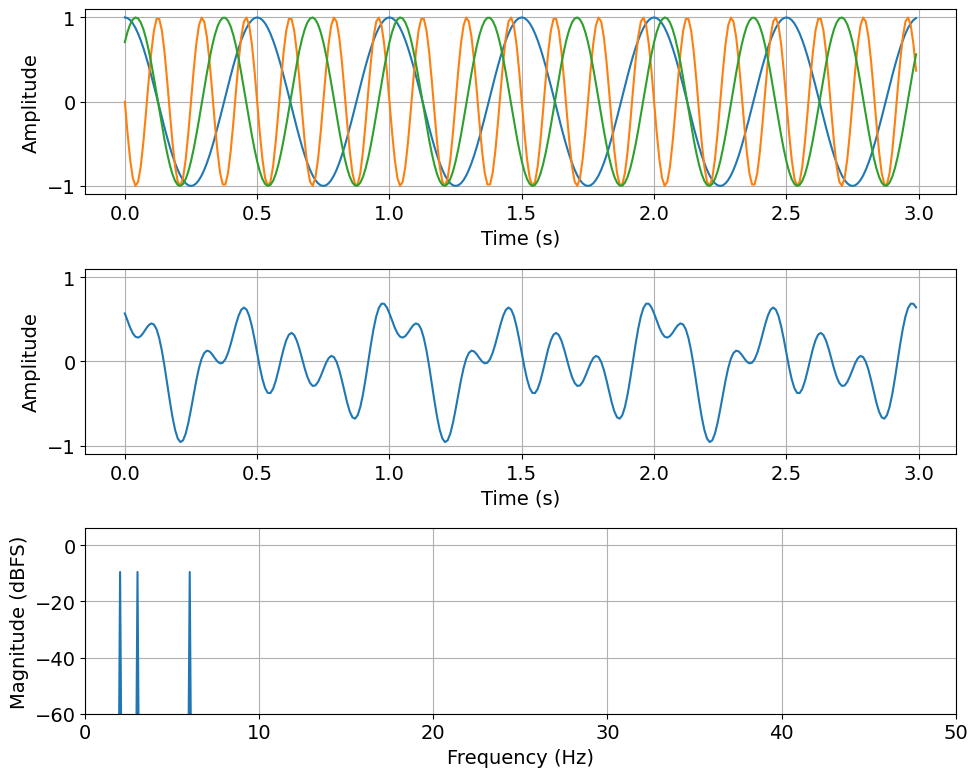

"\nplt.figure()\nf, X = signal.periodogram(x, Fs, scaling='spectrum')\nplt.plot(f, 10*np.log10(X))\nplt.ylim([-60, 0])\nplt.grid()\nplt.show()\n"

In [ ]:
# RAPPRESENTAZIONE NEL DOMINIO DELLA FREQUENZA
# SUONI COMPLESSI: SOMMA DI TONI PURI

Fs = 100
dur = 3

# tono 2 Hz
x1, t1 = gen_cos(dur=dur, Fs=Fs, amp=1, freq=2, phase=0)
# tono 6 Hz
x2, t2 = gen_cos(dur=dur, Fs=Fs, amp=1, freq=6, phase=np.pi/2)
# tono 3 Hz
x3, t3 = gen_cos(dur=dur, Fs=Fs, amp=1, freq=3, phase=-np.pi/4)

# tono np.sqrt(2)
x4, t3 = gen_cos(dur=dur, Fs=Fs, amp=1, freq=3, phase=-0)

# Componenti del segnale complesso xx
xx = [x1, x2, x3] # periodic
# xx = [x1, x2, x4] # non periodic

fig, [ax1, ax2, ax3] = plt.subplots(3,1, figsize=(10,8))
for x_ in xx:
  plot_vs_time(x_, t1,  ylim = [-1.1, +1.1], fig=(fig,ax1))

# Media somma dei toni
x = np.average(xx, axis=0)
t = t1

# fig, [ax1, ax2] = plt.subplots(2,1, figsize=(10,5))
plot_vs_time(x, t,  ylim = [-1.1, +1.1], fig=(fig,ax2), fmt='-')
X, f = dft(x, Fs)
plot_vs_freq(X, f, Fs, fig=(fig,ax3))

plt.show()

"""
plt.figure()
f, X = signal.periodogram(x, Fs, scaling='spectrum')
plt.plot(f, 10*np.log10(X))
plt.ylim([-60, 0])
plt.grid()
plt.show()
"""


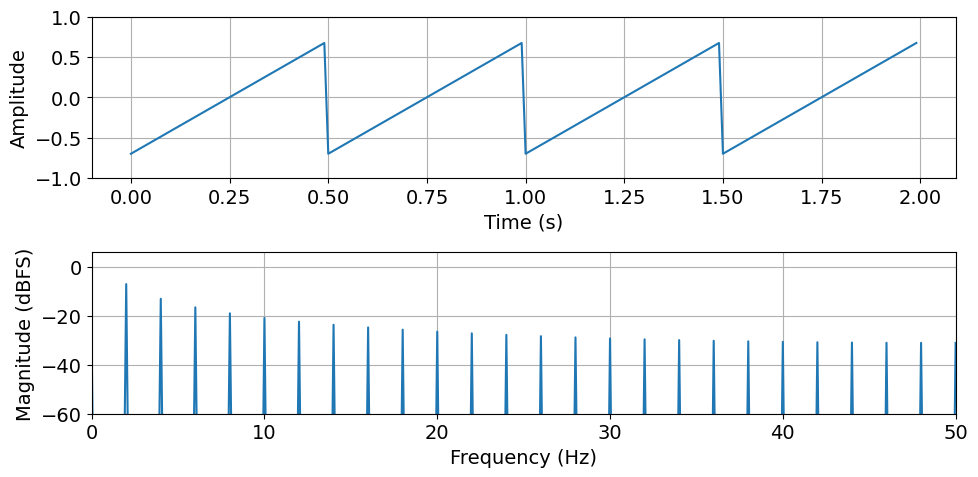

2.0: 0.00
4.0: 6.00
6.0: 9.50
8.0: 11.96
10.0: 13.84
12.0: 15.36
14.0: 16.63
16.0: 17.70


In [ ]:
# INVILUPPO SPETTRALE

from scipy.signal import sawtooth, find_peaks


Fs = 100
dur = 2
f0 = 2
A = 0.7
t = np.arange(dur*Fs)/Fs

x = A * signal.sawtooth(2 * np.pi * f0 * t)
# x = A * signal.square(2 * np.pi * f0 * t)


fig, [ax1, ax2] = plt.subplots(2,1, figsize=(10,5))

plot_vs_time(x, t, fig=(fig,ax1))

X, f = dft(x, Fs)
plot_vs_freq(X, f, Fs, fig=(fig,ax2))
plt.show()

"""
plt.figure(figsize=(10,3))
plt.magnitude_spectrum(x, Fs=Fs, scale='dB')
plt.ylim([-60, 0])
plt.grid()
plt.show()

plt.figure(figsize=(10,3))
f, X = signal.periodogram(x, Fs, scaling='spectrum')
plt.plot(f, 10*np.log10(X))
plt.ylim([-60, 0])
plt.grid()
plt.show()
"""

peaks, _ = find_peaks(X)  # tune distance as needed
p0 = peaks[0]
for p in peaks[0:8]:
  print(f"{f[p]}: {X[p0]-X[p]:.2f}")

# Features

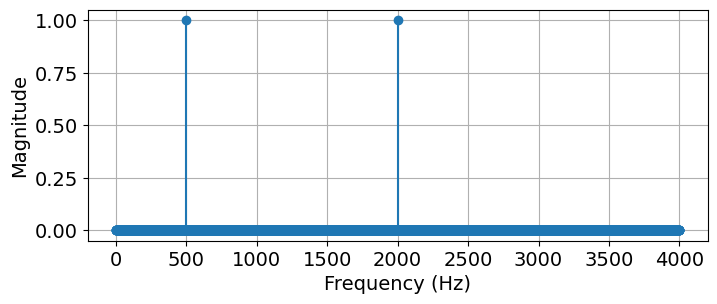

Spectral centroid: 1250.0 Hz
Spectral spread:   750.0 Hz


In [ ]:
# Calcolo dello spettro di ampiezza

fs = 8000
fa = 500
fb = 2000
t = np.linspace(0, 1.0, fs, endpoint=False)
signal = np.sin(2*np.pi* fa *t) + np.sin(2*np.pi* fb *t)

plt.figure(figsize=(8,3))
L = len(signal)
freqs = np.fft.rfftfreq(L, 1/fs)
spectrum = np.abs(np.fft.rfft(signal)) / (L/2)
plt.stem(freqs, spectrum, basefmt=" ")
plt.ylabel('Magnitude')
plt.xlabel('Frequency (Hz)')
plt.grid()
plt.show()

centroid = np.sum(freqs * spectrum) / np.sum(spectrum)
spread = np.sqrt(np.sum(((freqs - centroid) ** 2) * spectrum) / np.sum(spectrum))
print(f"Spectral centroid: {centroid:.1f} Hz")
print(f"Spectral spread:   {spread:.1f} Hz")

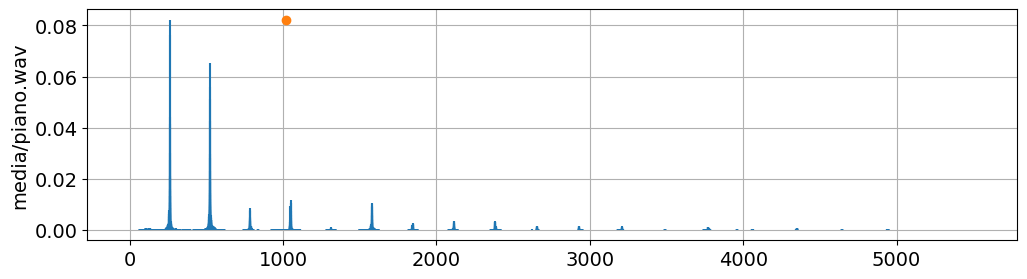

Spectral centroid: 1019.1 Hz
Spectral spread: 750.0 Hz


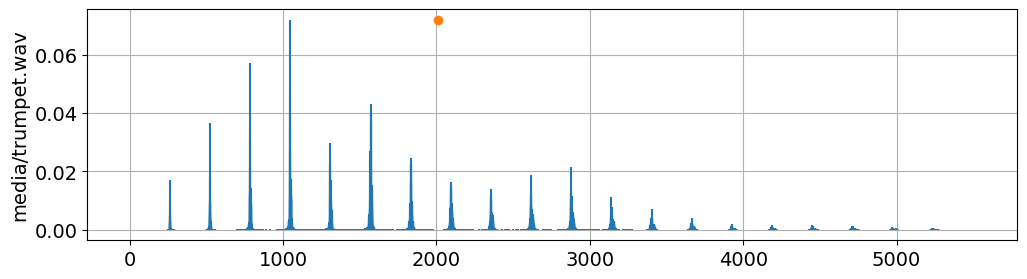

Spectral centroid: 2008.3 Hz
Spectral spread: 750.0 Hz


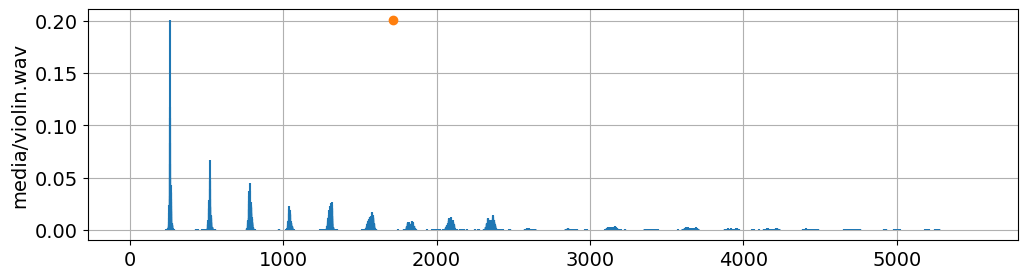

Spectral centroid: 1715.0 Hz
Spectral spread: 750.0 Hz


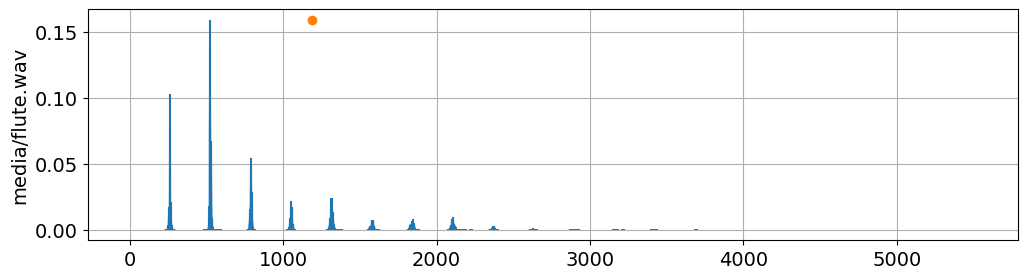

Spectral centroid: 1190.1 Hz
Spectral spread: 750.0 Hz


In [ ]:
audio_path = "media/piano.wav"

piano = 'media/piano.wav'
trumpet = 'media/trumpet.wav'
violin = "media/violin.wav"
flute = "media/flute.wav"

for audio_path in [piano, trumpet, violin, flute]:
  y, sr = librosa.load(audio_path, sr=None)


  plt.figure(figsize=(12,3))
  L = len(y)
  freqs = np.fft.rfftfreq(L,1/sr)
  spectrum = np.abs(np.fft.rfft(y))/(L/2)

  plt.stem(freqs, spectrum, basefmt=" ", markerfmt=" ")
  centroid = np.sum(freqs * spectrum) / np.sum(spectrum)
  plt.plot(centroid, np.max(spectrum), 'o')
  plt.ylabel(audio_path)
  #plt.ylabel('Magnitude')
  #plt.xlabel('Frequency (Hz)')
  plt.grid()
  plt.show()

  print(f"Spectral centroid: {centroid:.1f} Hz")
  print(f"Spectral spread: {spread:.1f} Hz")


[Text(0.5, 1.0, 'log Power spectrogram')]

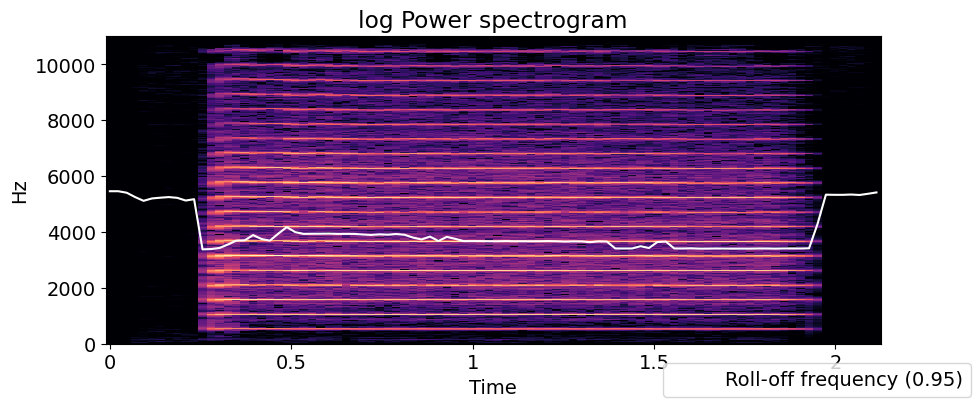

In [ ]:
# Spectral roll-off (via librosa)
audio_path = "media/trumpet.wav"
percent = 0.95
y, sr = librosa.load(audio_path, sr=None)
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=percent)
S, phase = librosa.magphase(librosa.stft(y))

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,4))
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='linear', x_axis='time', ax=ax)
ax.plot(librosa.times_like(rolloff), rolloff[0], label=f'Roll-off frequency ({percent})', color='w')
# ax.plot(librosa.times_like(rolloff), rolloff_min[0], color='w', label='Roll-off frequency (0.01)')
fig.legend(loc='outside lower right')
ax.set(title='log Power spectrogram')


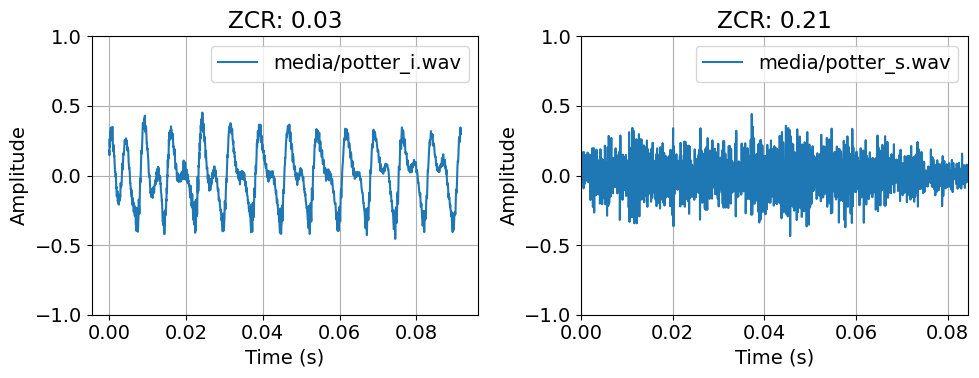

In [ ]:
# zero crossing rate

def zcr(x):
  # x [1, -1, -0.5, 1, -1]
  # sign [ 1. -1. -1. 1. -1.]
  # diff [-2. 0. 2. -2.]
  # count_nonzero 3
  # zcr 0.6 # i.e. 3/5
  return np.count_nonzero(np.diff(np.sign(x))) / len(x)

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,4))

audio_path = "media/potter_i.wav"
y, sr = librosa.load(audio_path, sr=None)
t = np.arange(len(y))/sr
plot_vs_time(y, t, fig=(fig,ax1))
ax1.set_title(f"ZCR: {zcr(y):.2f}")
ax1.legend([audio_path])

audio_path = "media/potter_s.wav"
y, sr = librosa.load(audio_path, sr=None)
t = np.arange(len(y))/sr
plot_vs_time(y, t, fig=(fig,ax2))
ax2.set_title(f"ZCR: {zcr(y):.2f}")
ax2.legend([audio_path])



Spectral flatness ((0.00)*noise + 1.00*tone):  0.000000


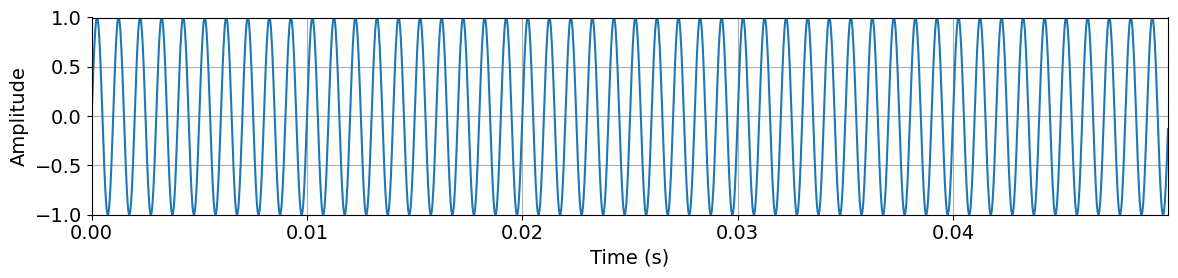

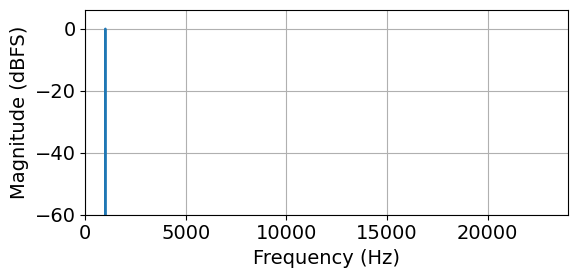

In [ ]:
import numpy as np
import scipy.signal as signal

def spectral_flatness(amplitude):
    # Avoid log(0)
    amplitude = np.maximum(amplitude, 1e-12)
    geometric_mean = np.exp(np.mean(np.log(amplitude)))
    arithmetic_mean = np.mean(amplitude)
    return geometric_mean / arithmetic_mean

# Example signals
fs = 48000
t = np.linspace(0, 0.05, int(fs*0.05), endpoint=False)

# A pure sinusoid (tone)
tone = signal.sawtooth(2*np.pi*1000*t)
tone = np.sin(2*np.pi*1000*t)


# White noise
noise = np.random.randn(len(t))

a = 1
signal = (1 - a)*noise + a*tone
t = np.arange(len(signal))/fs
L = len(signal)
spectrum = np.abs(np.fft.rfft(signal))/(L/2)
freqs = np.fft.rfftfreq(len(signal), 1/fs)
flatness = spectral_flatness(spectrum)

plot_vs_time(signal, t)
plot_vs_freq(20*np.log10(spectrum), freqs, fs)

print(f"Spectral flatness (({1-a:.2f})*noise + {a:.2f}*tone):  {flatness:.6f}")


# Segmentazione

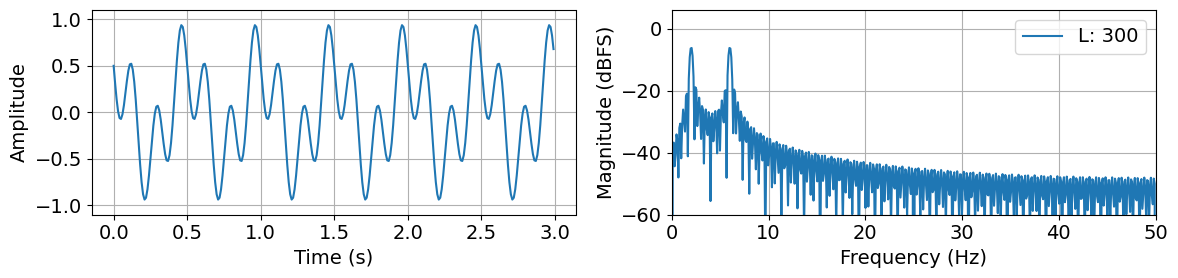

In [ ]:

Fs = 100
dur = 3

# tono 2 Hz
x1, t1 = gen_cos(dur=dur, Fs=Fs, amp=1, freq=2, phase=0)
# tono 6 Hz
x2, t2 = gen_cos(dur=dur, Fs=Fs, amp=1, freq=6, phase=np.pi/2)


# Media somma dei toni
x = np.average([x1, x2], axis=0)
t = t1

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12,3))
plot_vs_time(x, t,  ylim = [-1.1, +1.1], fig=(fig,ax1), fmt='-')
X, f = dft(x, Fs, N=1024)
plot_vs_freq(X, f, Fs, fig=(fig,ax2))

ax2.legend([f"L: {len(x)}"])
plt.show()





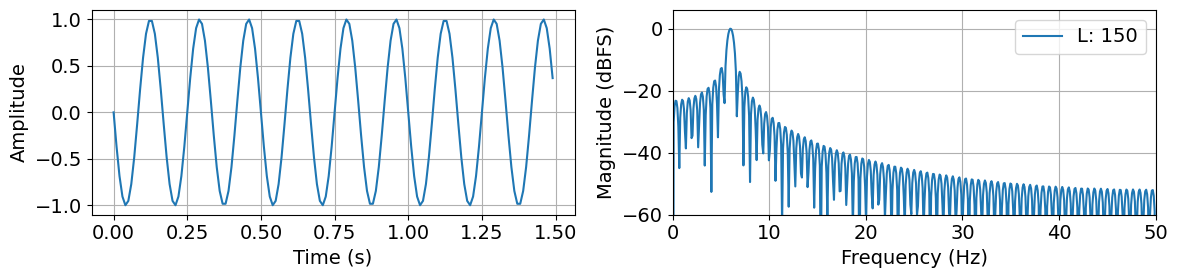

In [ ]:

Fs = 100
dur = 3/2

# tono 2 Hz
x1, t1 = gen_cos(dur=dur, Fs=Fs, amp=1, freq=2, phase=0)
# tono 6 Hz
x2, t2 = gen_cos(dur=dur, Fs=Fs, amp=1, freq=6, phase=np.pi/2)

# Concatenazione dei toni
x = np.concatenate([x1, x2], axis=0)
t = np.arange(len(x))/Fs

# x = x2
# t = t2

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12,3))
plot_vs_time(x, t,  ylim = [-1.1, +1.1], fig=(fig,ax1), fmt='-')
X, f = dft(x, Fs, N=1024)
plot_vs_freq(X, f, Fs, fig=(fig,ax2))

ax2.legend([f"L: {len(x)}"])
plt.show()



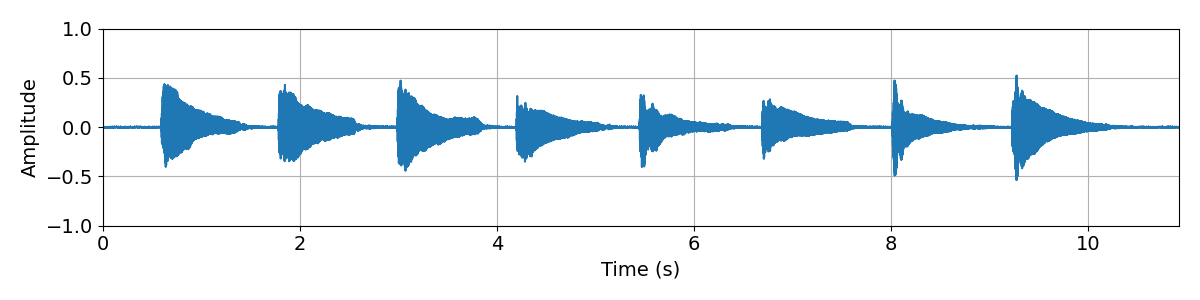

In [ ]:
audio_path = "media/piano-major-scale.wav"
y, sr = librosa.load(audio_path, sr=None)
t = np.arange(len(y))/sr
plot_vs_time(y,t)

"\ndur, A = 100, 1\nw, t = gen_wave(dur, Fs, A, f, ph, 'square')\n\nX, fx = dft(w, Fs, N=len(w))\nplot_vs_freq(X, fx/f, Fs, ylim=(-40,6), xlim=(0,15))\n"

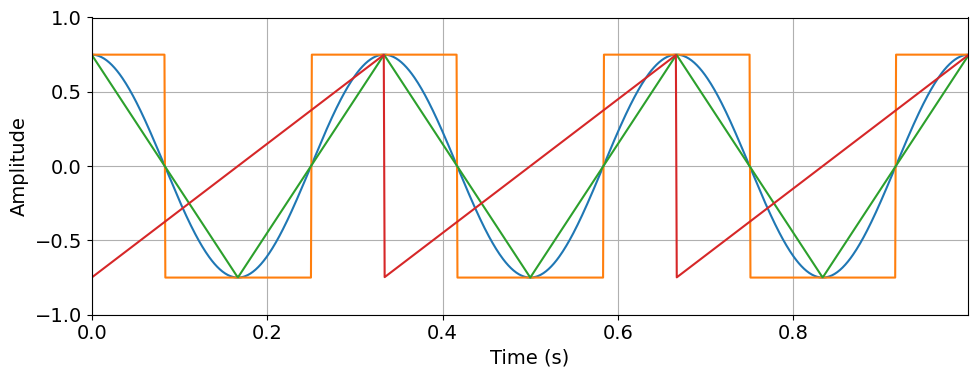

In [ ]:
# Segnali complessi

def gen_wave(dur, Fs, amp, freq, phase, type='sine'):
  c, t = gen_cos(dur=dur, Fs=Fs, amp=1, freq=freq, phase=phase)
  s, t = gen_cos(dur=dur, Fs=Fs, amp=1, freq=freq, phase=phase-np.pi/2)

  if type == 'sine': # indeed cosine
    w = amp * c
  elif type == 'square':
    w = amp * np.sign(c)
  elif type == 'triangle':
    w = amp * (2/np.pi) * np.arcsin(c)
  elif type == 'sawtooth':
    # recover phase
    phase = np.unwrap(np.arctan2(s, c))
    # normalize to [-1, +1]
    w = amp * ( (phase % (2*np.pi)) / np.pi - 1 )
  else:
    raise Exception('Unknown sound type')

  return w, t


fig, ax = plt.subplots(figsize=(10,4))

dur, Fs, A, f, ph = 1, 1000, 0.75, 3, 0
w, t = gen_wave(dur, Fs, A, f, ph, 'sine')
plot_vs_time(w,t, fig=(fig,ax))

w, t = gen_wave(dur, Fs, A, f, ph, 'square')
plot_vs_time(w,t, fig=(fig,ax))

w, t = gen_wave(dur, Fs, A, f, ph, 'triangle')
plot_vs_time(w,t, fig=(fig,ax))

w, t = gen_wave(dur, Fs, A, f, ph, 'sawtooth')
plot_vs_time(w,t, fig=(fig,ax))

"""
dur, A = 100, 1
w, t = gen_wave(dur, Fs, A, f, ph, 'square')

X, fx = dft(w, Fs, N=len(w))
plot_vs_freq(X, fx/f, Fs, ylim=(-40,6), xlim=(0,15))
"""


In [ ]:
base_folder = "/content/gdrive/MyDrive/EAD26/media/iowa/"
flute = "Flute.nonvib.ff.C4.stereo.aif"
clarinet = "BbClarinet.ff.C4.stereo.aif"
oboe = "Oboe.ff.C4.stereo.aif"
trumpet = "Trumpet.vib.ff.C4.stereo.aif"

cymbal = "../16285__ltibbits__splash-zxt-flash-10-high-vol.wav"

#
C4 = 261.63 # Hz


filename = cymbal

y, sr = librosa.load(f"{base_folder}/{filename}", sr=None)
y = y/np.max(np.abs(y))
# plot_vs_time(y, np.arange(len(y))/sr)

X, fx = dft(y, sr)
plot_vs_freq(X, fx, sr)




/tmp/ipython-input-3142126115.py:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(f"{base_folder}/{filename}", sr=None)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/MyDrive/EAD26/media/iowa//../16285__ltibbits__splash-zxt-flash-10-high-vol.wav'

In [ ]:
audio_path = "/content/flute_a4.mp3"  # Replace with your file
audio_path = "/content/banjo_a4.mp3"
sr = 44100/4
y, sr = librosa.load(audio_path, sr=sr)

y = y/np.max(np.abs(y))

"""
n1 = int(0.2 * sr)
n2 = int(0.8 * sr)

y = y[n1:n2]
"""

plot_vs_time(y, np.arange(len(y))/sr)

X, f = dft(y, sr)
X[f<200] = -100 # remove low frequency hum
plot_vs_freq(X, f, sr)

In [ ]:
filename = "/content/piano-major-scale.FMP_C2_F10.wav"

y, sr = librosa.load(filename, sr=None)
t = np.arange(len(y))/sr
plot_vs_time(y, t)

t1 = 1.77
t2 = t1+0.05
n1 = int(t1*sr)
n2 = int(t2*sr)

y = y[n1:n2]
y = y/np.max(np.abs(y))

plot_vs_time(y, np.arange(len(y))/sr+t1, xlim=[t1,t2])



In [ ]:


# ==============================
# 1. Load Audio
# ==============================
# audio_path = "/content/Bilabial_nasal.ogg"  # Replace with your file
audio_path = "/content/dizione-italiana-accento-grave-acuto.intro.wav"
y, sr = librosa.load(audio_path, sr=None)


"""
# Extract portion from t1 to t2

t1 = 1.3
t2 = 1.4

start_sample = int(t1 * sr)
end_sample = int(t2 * sr)

y = y[start_sample:end_sample]
"""


duration = librosa.get_duration(y=y, sr=sr)
time = np.linspace(0, duration, len(y))


In [ ]:

# ==============================
# 2. Feature Computation
# ==============================
def compute_spectral_centroid(y, sr):
    sc = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=512)
    return np.array(sc.squeeze())

def compute_hber(y, sr, threshold_hz=3000):
    S = np.abs(librosa.stft(y, n_fft=512))**2
    freqs = librosa.fft_frequencies(sr=sr, n_fft=512)
    high_band = S[freqs > threshold_hz, :]
    total_energy = S.sum(axis=0)
    high_energy = high_band.sum(axis=0)
    return np.array(high_energy / (total_energy + 1e-8))

def compute_hnr(y, sr):
  try:
    snd = parselmouth.Sound(y, sr)
    hnr_obj = snd.to_harmonicity_cc() # frame 10 ms
    return np.array(hnr_obj.values.T.squeeze())
  except Exception as e:
    print(e)
    return np.array([])

def detect_burst(y, sr, win_size=0.02, threshold=0.6):
  try:
    frame_len = int(sr * win_size)
    energy = np.array([
        np.sum(y[i:i+frame_len]**2)
        for i in range(0, len(y)-frame_len, frame_len)
    ])
    energy /= energy.max()
    return np.array(energy > threshold)
  except Exception as e:
      print(e)
      return np.array([])

# ==============================
# 3. Compute Features
# ==============================
sc = compute_spectral_centroid(y, sr)
hber = compute_hber(y, sr)
hnr = compute_hnr(y, sr)
burst_flags = detect_burst(y, sr)

print(f"Spectral centroid: {np.average(np.array(sc))} Hz")
print(f"High-Band Energy Ratio: {np.average(np.array(hber))}")
print(f"Harmonics-to-Noise Ratio: {np.average(np.array(hnr))} dB")
# burst_flags = detect_burst(y, sr)
print(f"Burst flags: {''.join(['|' if b else '_' for b in burst_flags])}")

# Time axes
frames = np.arange(sc.shape[0])
times_sc = librosa.frames_to_time(frames, sr=sr)
frames_hber = np.arange(hber.shape[0])
times_hber = librosa.frames_to_time(frames_hber, sr=sr)
times_hnr = np.linspace(0, duration, len(hnr))

# ==============================
# 4. Visualization
# ==============================
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# (a) Waveform
axes[0].plot(time, y, color='black')
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Waveform")
axes[0].grid()

# (b) Spectral Centroid
axes[1].plot(times_sc, sc, color='blue')
axes[1].set_ylabel("Centroid (Hz)")
axes[1].set_title("Spectral Centroid")
axes[1].grid()

# (c) High-Band Energy Ratio
axes[2].plot(times_hber, hber, color='green')
axes[2].set_ylabel("HBER")
axes[2].set_title("High-Band Energy Ratio")
axes[2].grid()

# (d) Harmonics-to-Noise Ratio
axes[3].plot(times_hnr, hnr, color='red')
axes[3].set_ylabel("HNR (dB)")
axes[3].set_xlabel("Time (s)")
axes[3].set_title("Harmonics-to-Noise Ratio")
axes[3].set_ylim(-20, 30)
axes[3].grid()

# Set useblit=True on most backends for enhanced performance.
# cursor = Cursor(axes[0], useblit=True, color='red', linewidth=2)


plt.tight_layout()
plt.show()




In [ ]:
sr

In [ ]:
import pandas as pd

# audio_path = "/content/Bilabial_nasal.ogg"  # Replace with your file
audio_path = "/content/dizione-italiana-accento-grave-acuto.intro.wav"
y, sr = librosa.load(audio_path, sr=None)

duration = librosa.get_duration(y=y, sr=sr)
time = np.linspace(0, duration, len(y))

# md5sum 5544443890e413c871357cb97f9c0729  dizione-italiana-accento-grave-acuto.intro.wav
phonemes = [
    { 'phon': 'z', 'start': 3.259, 'end': 3.296 },
    { 'phon': 'a', 'start': 3.543, 'end': 3.664 },
    { 'phon': 'p', 'start': 3.744, 'end': 3.761 },
    { 'phon': 's', 'start': 6.632, 'end': 6.723 },
    { 'phon': 'e', 'start': 7.877, 'end': 7.974 },
    { 'phon': 'E', 'start': 8.513, 'end': 8.627 },
    { 'phon': 's', 'start': 8.641, 'end': 8.726 },

]

e_closed = [
{ 'phon': 'e', 'start': 0.58, 'end': 0.62 },
{ 'phon': 'e', 'start': 1.62, 'end': 1.70 },
{ 'phon': 'e', 'start': 2.47, 'end': 2.51 },
{ 'phon': 'e', 'start': 2.85, 'end': 2.91 },
{ 'phon': 'e', 'start': 2.96, 'end': 3.01 },
{ 'phon': 'e', 'start': 3.30, 'end': 3.38 },
{ 'phon': 'e', 'start': 4.66, 'end': 4.71 },
{ 'phon': 'e', 'start': 7.90, 'end': 7.96 },
{ 'phon': 'e', 'start': 10.86, 'end': 10.93 },
{ 'phon': 'e', 'start': 12.54, 'end': 12.63 }
]

e_open = [
{ 'phon': 'E', 'start': 2.29, 'end': 2.36 },
{ 'phon': 'E', 'start': 6.49, 'end': 6.61 },
{ 'phon': 'E', 'start': 8.52, 'end': 8.60 },
{ 'phon': 'E', 'start': 11.44, 'end': 11.53 }
]

"""
# e chiusa
{ 'phon': 'e', 'start': 0.58, 'end': 0.62 },
{ 'phon': 'e', 'start': 1.62, 'end': 1.70 },
{ 'phon': 'e', 'start': 2.47, 'end': 2.51 },
{ 'phon': 'e', 'start': 2.85, 'end': 2.91 },
{ 'phon': 'e', 'start': 2.96, 'end': 3.01 },
{ 'phon': 'e', 'start': 3.30, 'end': 3.38 },
{ 'phon': 'e', 'start': 4.66, 'end': 4.71 },
{ 'phon': 'e', 'start': 7.90, 'end': 7.96 },
{ 'phon': 'e', 'start': 10.86, 'end': 10.93 },
{ 'phon': 'e', 'start': 12.54, 'end': 12.63 },

# E aperta
{ 'phon': 'E', 'start': 2.29, 'end': 2.36 },
{ 'phon': 'E', 'start': 6.49, 'end': 6.61 },
{ 'phon': 'E', 'start': 8.52, 'end': 8.60 },
{ 'phon': 'E', 'start': 11.44, 'end': 11.53 },




"""

phonemes_df = pd.DataFrame(e_open)

for i, ph in phonemes_df.iterrows():
  s = int(sr * ph['start'])
  e = int(sr * ph['end'])
  c = (s+e) / 2
  dur = e - s
  x = y[s:e]

  """
  # extract only central part of phoneme, c.a. 80% of total duration
  c = (s+e) / 2
  perc = 0.8
  s = c - dur/2 * perc
  e = c + dur/2 * perc
  x = y[int(s):int(e)]
  """


  dur_t = ph['end'] - ph['start']
  rms = RMS(x)

  # print("Phoneme:", ph)

  # print("Samples:", dur)
  phonemes_df.loc[i, 'samples'] = dur

  # print("Duration (ms)", int(dur_t*1000))
  phonemes_df.loc[i, 'duration'] = dur_t

  # print("Energy (RMS):", rms)
  phonemes_df.loc[i, 'rms'] = rms

  # ==============================
  # 3. Compute Features
  # ==============================
  sc = compute_spectral_centroid(x, sr)
  hber = compute_hber(x, sr)
  hnr = compute_hnr(x, sr)

  phonemes_df.loc[i, 'sc'] = np.average(sc)
  phonemes_df.loc[i, 'hber'] = np.average(hber)
  phonemes_df.loc[i, 'hnr'] = np.average(hnr)
  # print(f"Spectral centroid: {sc.shape}, {np.average(sc)} Hz")
  # print(f"High-Band Energy Ratio: {hber.shape}, {np.average(hber)}")
  # print(f"Harmonics-to-Noise Ratio: {hnr.shape}, {np.average(hnr)} dB")


print(phonemes_df.sort_values(by=['phon']).to_markdown())

ChatGPT: https://chatgpt.com/c/68ac7e61-9368-8327-9175-4a91de3251e6

Sample Rate: 22050 Hz

| **Feature**                        | **/a/** (voiced vowel) | **/s/** (unvoiced fricative) | **/z/** (voiced fricative)         | **/p/** (unvoiced plosive)     | **Reason to Include**                  |
| ---------------------------------- | ---------------------- | ---------------------------- | ---------------------------------- | ------------------------------ | -------------------------------------- |
| **Spectral Centroid (SC)**         | Low (\~800–1200 Hz)    | High (\~4000–7000 Hz)        | Medium (\~2500–4000 Hz)            | Medium (\~2000–3500 Hz)        | Shows distribution of spectral energy  |
| **High-Band Energy Ratio (HBER)**  | Low                    | High                         | High (but slightly lower than /s/) | Medium (burst, short duration) | Discriminates vowels vs fricatives     |
| **Harmonics-to-Noise Ratio (HNR)** | High (>15 dB)          | Low (<5 dB)                  | Medium (\~8–12 dB)                 | Very low (<3 dB)               | Distinguishes periodic vs noisy sounds |
| **Zero-Crossing Rate (ZCR)**       | Low                    | High                         | Medium                             | High (but short burst)         | Highlights fricatives and plosives     |
| **Short-Term Energy (STE)**        | Stable, high           | Medium                       | Medium                             | Very high but short            | Good to detect plosive bursts          |


sdfd


|    | phon   |   start |   end |   samples |   duration |        rms |      sc |        hber |       hnr |
|---:|:-------|--------:|------:|----------:|-----------:|-----------:|--------:|------------:|----------:|
|  5 | E      |   8.513 | 8.627 |      2514 |      0.114 | 0.0818797  | 1357.56 | 0.00453027  |   5.57989 |
|  1 | a      |   3.543 | 3.664 |      2668 |      0.121 | 0.118195   | 1259.11 | 0.000487493 |   9.75943 |
|  4 | e      |   7.877 | 7.974 |      2139 |      0.097 | 0.210948   | 1310.72 | 0.00143155  |   9.98737 |
|  2 | p      |   3.744 | 3.761 |       375 |      0.017 | 0.00979093 | 1702.17 | 0.00825369  | nan       |
|  3 | s      |   6.632 | 6.723 |      2007 |      0.091 | 0.0445958  | 6217.06 | 0.939147    |  -2.3252  |
|  6 | s      |   8.641 | 8.726 |      1874 |      0.085 | 0.0283652  | 6285.58 | 0.937766    |  -3.78969 |
|  0 | z      |   3.259 | 3.296 |       816 |      0.037 | 0.0213734  | 4741.54 | 0.21124     |  10.089   |

In [ ]:
rxx_t = 0.9

20*np.log10(0.3/0.7)

In [ ]:
import numpy as np
x = [1, -1, -0.5, 1, -1]
np.count_nonzero(np.diff(np.sign(x)))

In [ ]:
def dft(x, Fs):
  L = len(x)
  X = np.abs(np.fft.rfft(x)) / (L/2)
  freq = np.fft.rfftfreq(L, d=1./Fs)
  # X_ = X_[:N//2+1]
  # freq = freq[:N//2+1]
  X_dBFS = 20*np.log10(X)
  return X_dBFS, freq

# plot frequency spectrum
def plot_vs_freq(X, f, Fs, xlim=None, ylim=None, fig=None):
  xlim = [np.min(f), np.max(f)] if xlim is None else xlim
  ylim = [-60, +0] if ylim is None else ylim

  fig, ax = plt.subplots(figsize=(6,3)) if fig is None else fig

  # ax.stem(f, X, bottom=-100, basefmt=" ", label=f"N={N}")

  """
  print('len(X_dBFS): ', len(X_dBFS), 'len(freq): ', len(freq))
  print('len(x):', len(x))
  print('freq:', freq)
  """

  ax.plot(f, X, '-')

  ax.set_xlabel('Frequency (Hz)')
  ax.set_ylabel('Magnitude (dBFS)') # Modulo
  # print(f'N: {N}, freq: {np.min(freq)}, {np.max(freq)}')
  # plt.xlim([np.min(freq), -np.min(freq)])
  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  plt.grid(visible=True);
  plt.tight_layout()

# plot_vs_freq(x, Fs, N)
# plot_vs_freq(x, Fs, N, xlim=[2, 5], ylim=[-10, 3])

audio_path = "/content/potter_s.wav"
audio_path = "/content/potter_i.wav"
audio_path = "/content/trumpet.wav"


y, sr = librosa.load(audio_path, sr=None)
# print(y.shape)

y = y/np.max(np.abs(y))
# y = y - np.average(y)
t = np.arange(len(y))/sr

plot_vs_time(y, t)

X, f = dft(y, sr)

plot_vs_freq(X, f, sr)


from scipy.signal import welch, get_window
nperseg = 2048
noverlap = nperseg // 2
freqs_welch, Pxx_welch = welch(
    y, sr, window='hann', nperseg=nperseg, noverlap=noverlap
)
Pxx_welch_db = 10 * np.log10(Pxx_welch + 1e-12)

plt.figure(figsize=(6, 3))
plt.plot(freqs_welch, Pxx_welch_db, label="Welch (avg. 512-point FFTs)", alpha=0.9)
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()


In [ ]:

import numpy as np


## computes the spectral centroid from the (squared) magnitude spectrum
def FeatureSpectralCentroid(X, f_s):

    isSpectrum = X.ndim == 1

    # X = X**2 removed for consistency with book

    norm = X.sum(axis=0, keepdims=True)
    norm[norm == 0] = 1

    vsc = np.dot(np.arange(0, X.shape[0]), X) / norm

    # convert from index to Hz
    vsc = vsc / (X.shape[0] - 1) * f_s / 2

    # if input is a spectrum, output scaler else if spectrogram, output 1d array
    vsc = np.squeeze(vsc) if isSpectrum else np.squeeze(vsc, axis=0)

    return vsc


## computes the spectral slope from the magnitude spectrum
def FeatureSpectralSlope(X, f_s):

    # compute mean
    vsc = FeatureSpectralCentroid(X, f_s) * 2 / f_s * (X.shape[0] - 1)

    # compute index vector
    kmu = np.arange(0, X.shape[0]) - (X.shape[0]+1) / 2

    # compute slope
    X = X - vsc
    vssl = np.dot(kmu, X) / np.dot(kmu, kmu)

    return vssl
